<img src="../../images/wt4.png" align="right" width="70"/>

  #     Notebook for early gear fault detection for WT01



## Table of contents
1. Load Raw signal
2. Resample Signal into Order Domain
3. Development of the First 15 Orders
4. Development of the First 200 Orders
5. All Orders
6. RMS all Signals wtih Avg Power > 2700

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
from scipy.stats import kurtosis, skew

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload 2
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff,data_statistics


appended
appended
appended
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src
ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


## 1. Load Raw Signal

In [4]:
turbine = 'wt01'
vib_signal, times, op_data_intervals, peak_array = load_raw_signals.load_raw('gearbox',turbine)
avg_rpm = np.asarray(op_data_intervals['AvgSpeed'])
avg_power = np.asarray(op_data_intervals['AvgPower'])
time = times[0]

wt_folder_path = f'/Volumes/OsvikExtra/signal_data/raw_data/gearbox/{turbine}/'
dates = pd.read_csv(f'{wt_folder_path}interval_dates_{turbine}.csv')
dates = dates.drop(columns=['Unnamed: 0'])



File exist


## 2. Resample Signal into Order Domain

In [5]:
resampled_xs = []
resampled_ys = []
data_size = vib_signal.shape[0]
for i, vib_sig in enumerate(vib_signal):
    x_round, resampled_y, _ = resample_signals.do_cubic_resampling(time, vib_sig, peak_array[i], number_of_resample_points=2000)
    resampled_xs.append(x_round)
    resampled_ys.append(resampled_y)
    print(f'Resampled {i+1} / {data_size} signals', end='\r')


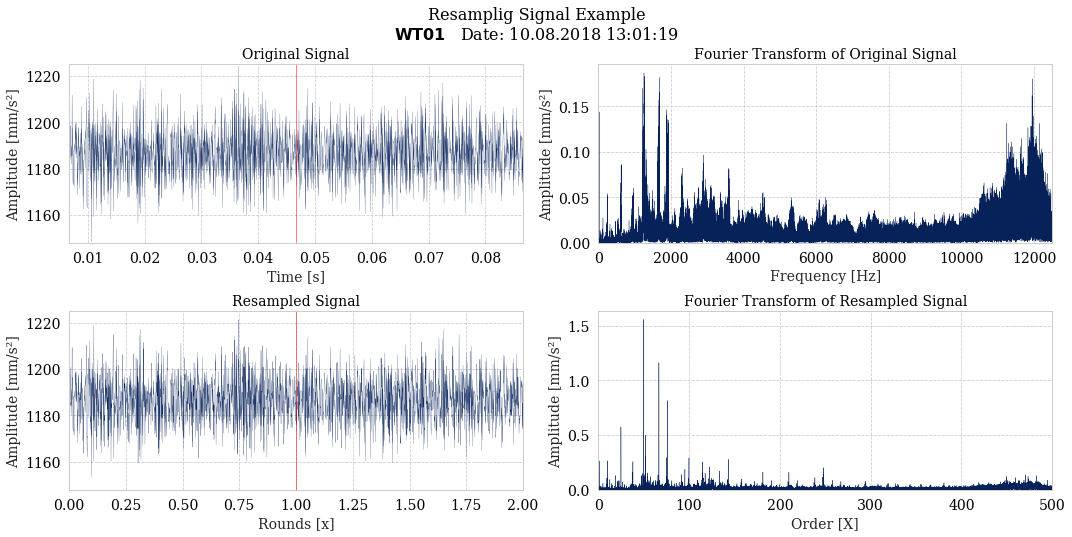

In [11]:
plot_path = f'../../plots/results/'
def normalise_fft(fft):
    N = fft.shape[0]
    y = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    return y

def flip_date(date):
    splitted_date = date.split('-')
    year  = splitted_date[0]
    month = splitted_date[1]
    day   = splitted_date[2].split(' ')[0]
    time  = splitted_date[2].split(' ')[1]
    new_date = day + '.' + month + '.' + year + ' ' + time
    return new_date

rows = 2
cols = 2

fig, ax = plt.subplots(rows, cols,figsize=(15,7))
dato = flip_date(dates.values[i][0])
heading = 'Resamplig Signal Example'
heading += '\n' + r"$\bf{WT01}$"  f'   Date: {dato}'
my_suptitle = fig.suptitle(heading,fontsize=16, y=1.06)

row = 0
ax[row,0].plot(plot_signal_x[row], plot_signal_y[row], linewidth=0.2)
ax[row,0].set_title(f"Original Signal")
ax[row,0].set_ylabel("Amplitude [mm/s\u00b2]")
ax[row,0].set_xlabel("Time [s]")
ax[row,0].set_xlim(peak_array[i][0], peak_array[i][2])
ax[row,0].set_ylim(1148, 1225)
ax[row,0].axvline(peak_array[i][1], c='r', linewidth=0.5)


ax[row,1].plot(plt_fft_x[row], plt_fft_y[row],linewidth=0.3)
ax[row,1].set_title(f"Fourier Transform of Original Signal")
ax[row,1].set_ylabel("Amplitude [mm/s\u00b2]")
ax[row,1].set_xlabel("Frequency [Hz]")
ax[row,1].set_xlim(0, 12500)
ax[row,1].set_ylim(bottom=0)



row = 1 
ax[row,0].plot(plot_signal_x[row], plot_signal_y[row], linewidth=0.2)
ax[row,0].set_title(f"Resampled Signal")
ax[row,0].set_ylabel("Amplitude [mm/s\u00b2]")
ax[row,0].set_xlabel("Rounds [x]")
ax[row,0].set_xlim(0, 2)
ax[row,0].set_ylim(1148, 1225)
ax[row,0].axvline(1, c='r', linewidth=0.5)


ax[row,1].plot(plt_fft_x[row], plt_fft_y[row], linewidth=0.4)
ax[row,1].set_title(f"Fourier Transform of Resampled Signal")
ax[row,1].set_ylabel("Amplitude [mm/s\u00b2]")
ax[row,1].set_xlabel("Order [X]")
ax[row,1].set_xlim(0, 500)
ax[row,1].set_ylim(bottom=0)


plt.tight_layout()
#plt.margins(0)
plt.savefig(f'{plot_path}resample_example.png', dpi=300, bbox_extra_artists=[my_suptitle], bbox_inches='tight')
plt.show()


In [27]:
resampled_wt_path = f'../../../../../../signal_data/resampled_order/gearbox/{turbine}/'
num_csvs = len([f for f in os.listdir(resampled_wt_path) 
     if f.endswith('.csv.zip') and os.path.isfile(os.path.join(resampled_wt_path, f)) and f[0]=='r'])

res_x = []
res_y = []

for i in range(num_csvs):
    save_path = f'{resampled_wt_path}resampled_order_20000_{i}.csv.zip'
    df = pd.read_csv(f'{resampled_wt_path}resampled_order_20000_{i}.csv.zip', compression='gzip')
    res_x.append(df['order'].values)
    res_y.append(df['y'].values)
    print(f'Loaded {i+1} / {num_csvs} signals', end='\r')
    

In [25]:
datasize = len(resampled_xs)
#resampled_wt_path = f'/Volumes/OsvikExtra/signal_data/resampled_order/gearbox/{turbine}/'
resampled_wt_path = f'../../../../../../signal_data/resampled_order/gearbox/{turbine}/'

for i in range(datasize):
    save_path = f'{resampled_wt_path}resampled_order_20000_{i}.csv.zip'
    data = np.array([resampled_xs[i], resampled_ys[i]])
    df = pd.DataFrame(data.T, columns=['order', 'y'])
    df.to_csv(save_path, index=False, compression='gzip')
    print(f'Saved {i+1} / {datasize}', end='\r')
    

## 3. Development of the First 15 Orders

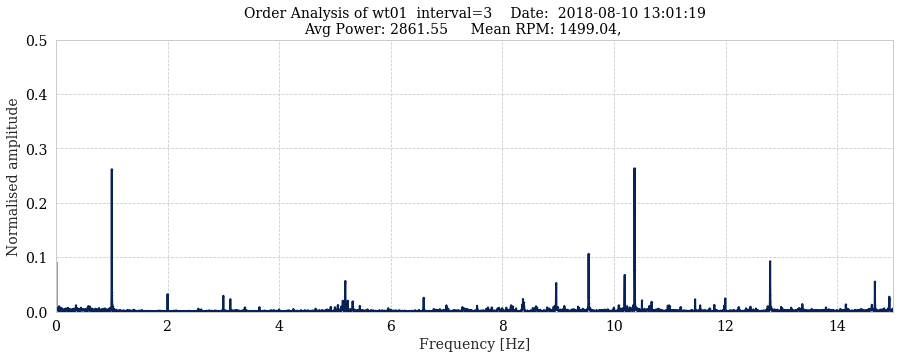

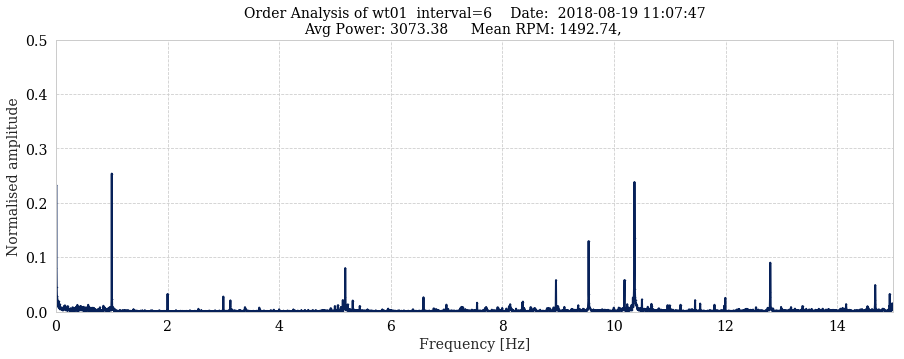

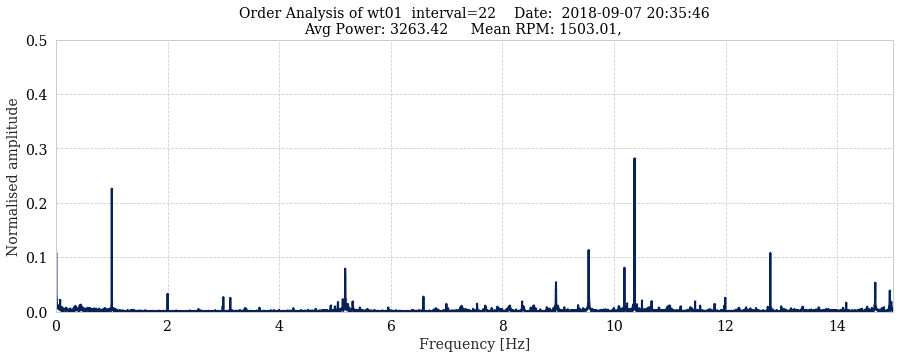

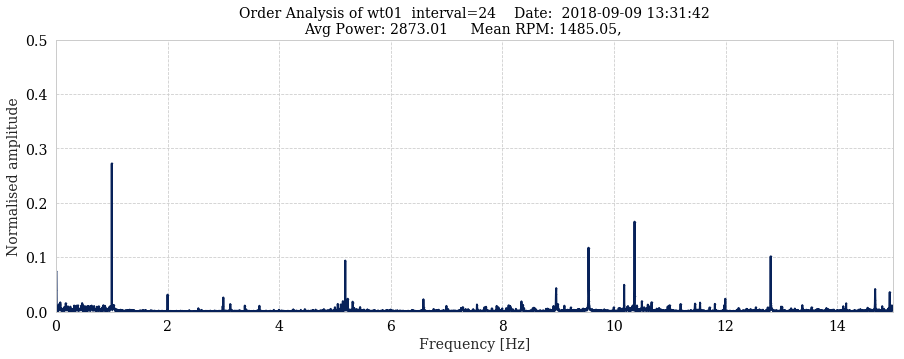

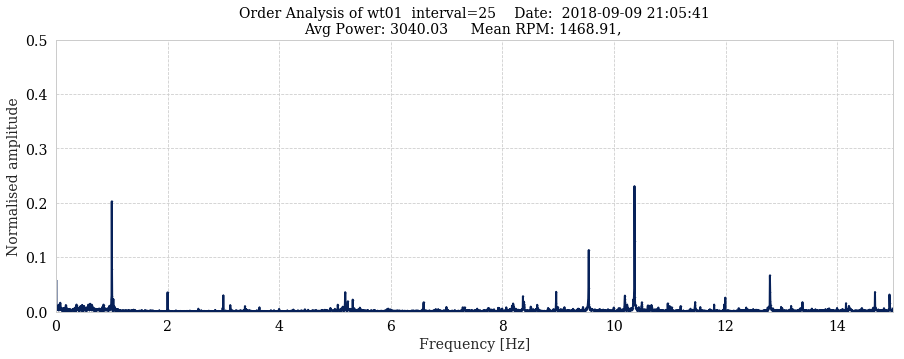

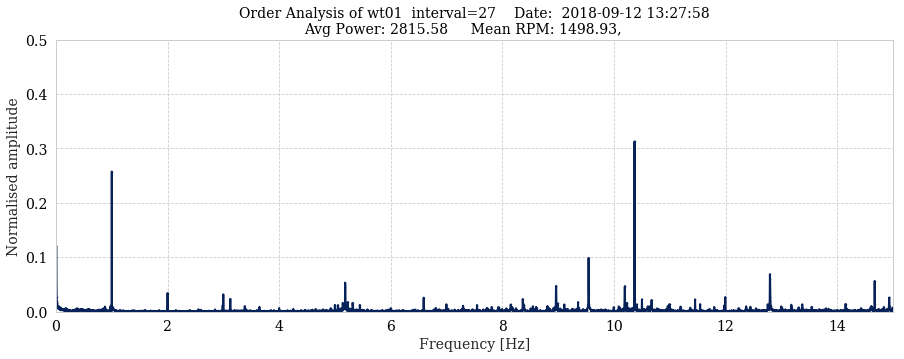

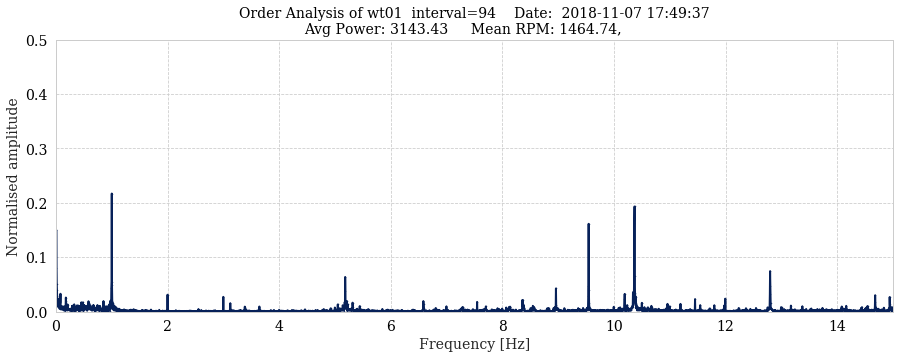

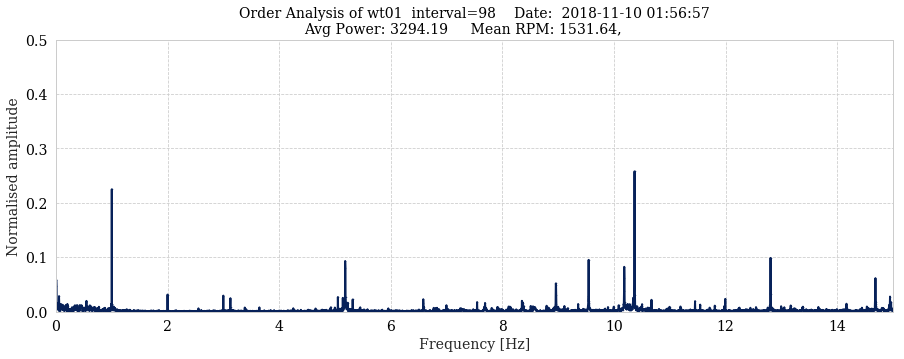

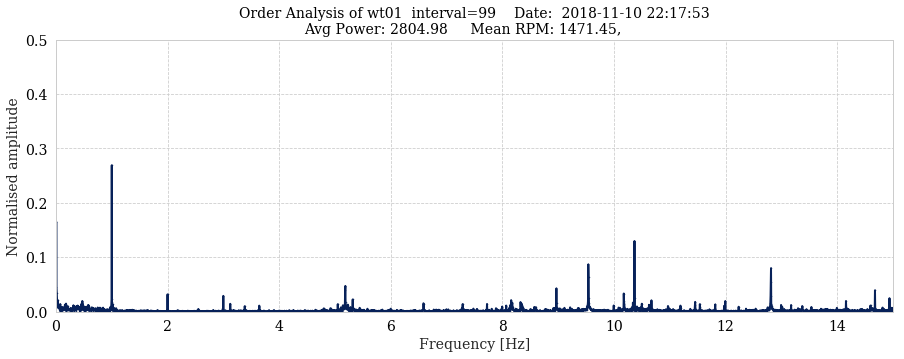

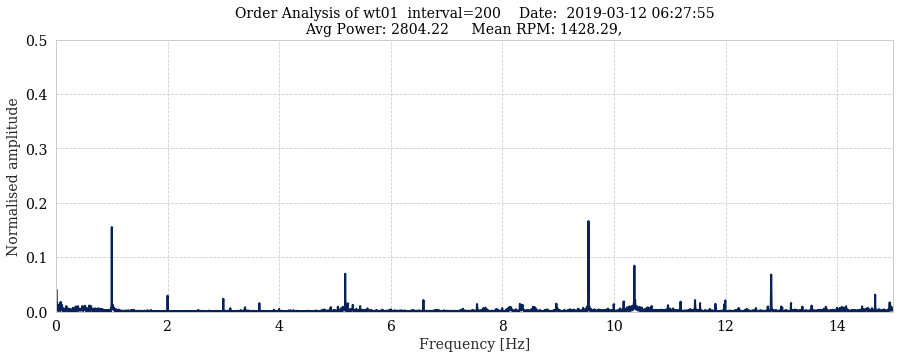

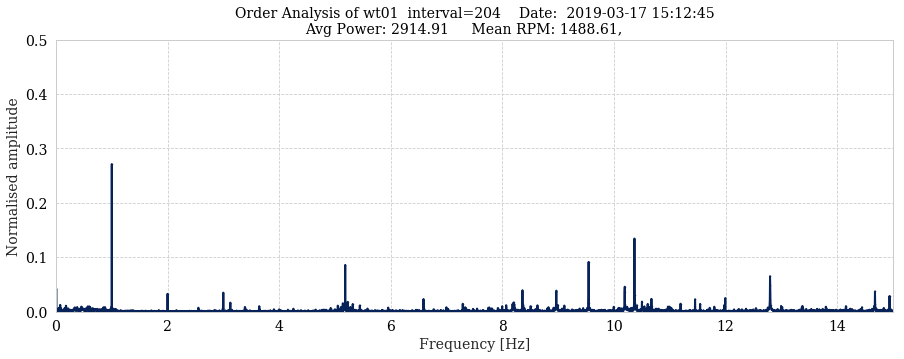

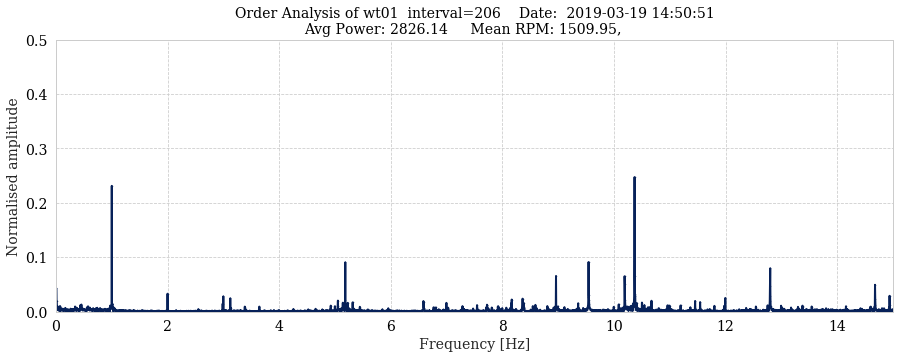

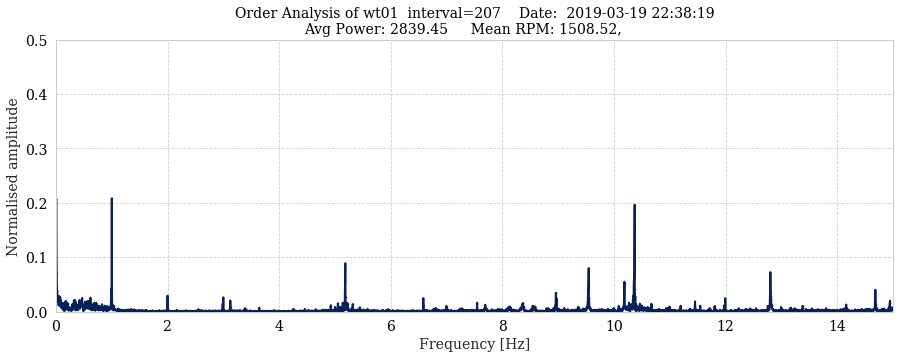

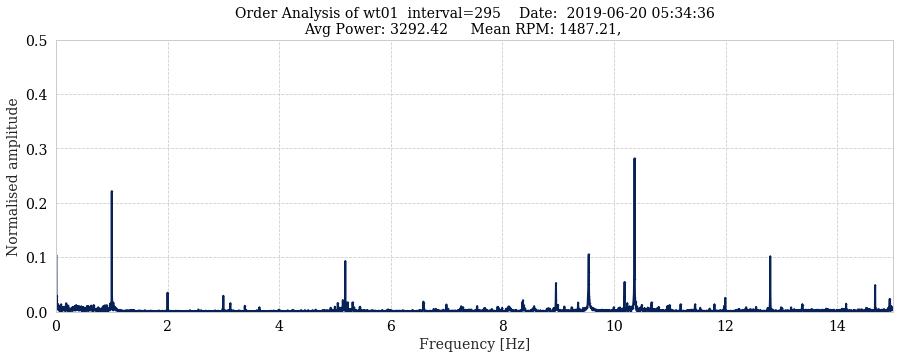

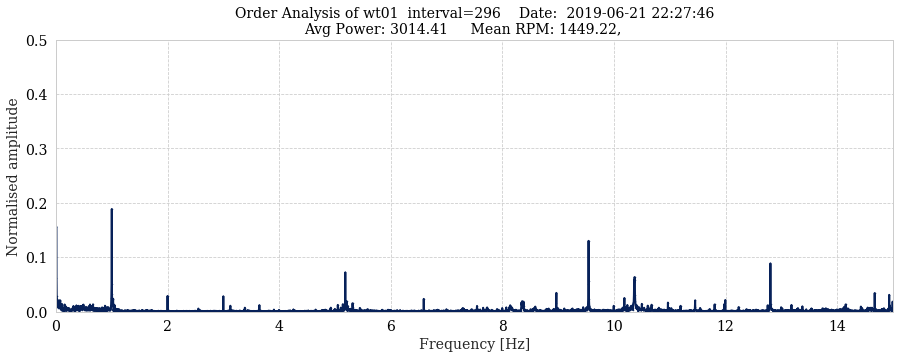

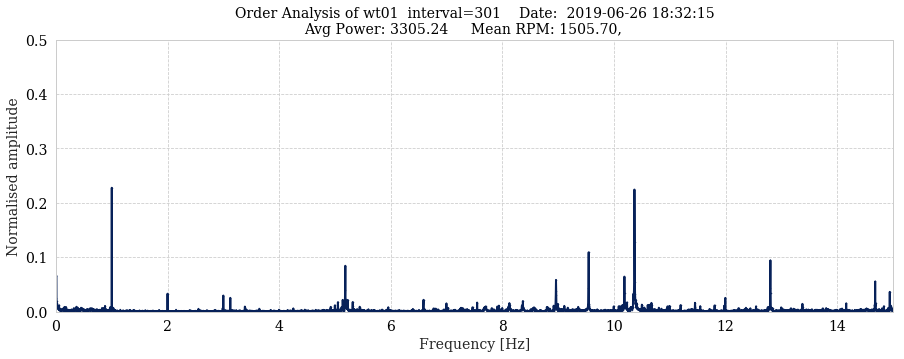

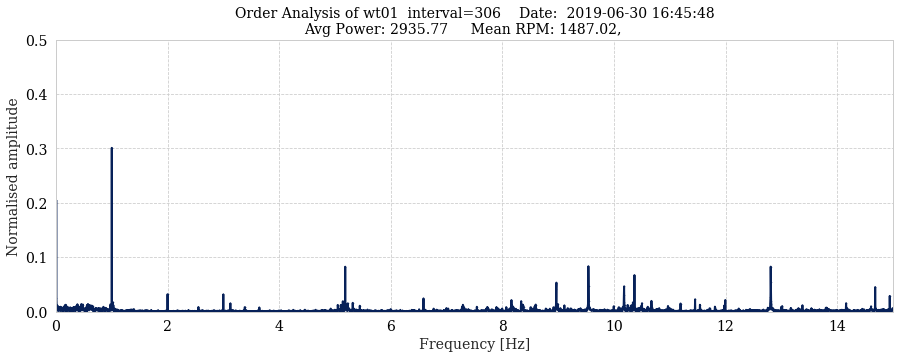

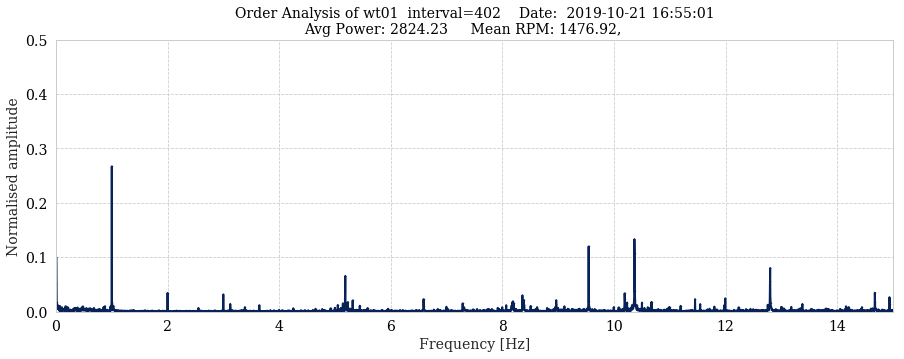

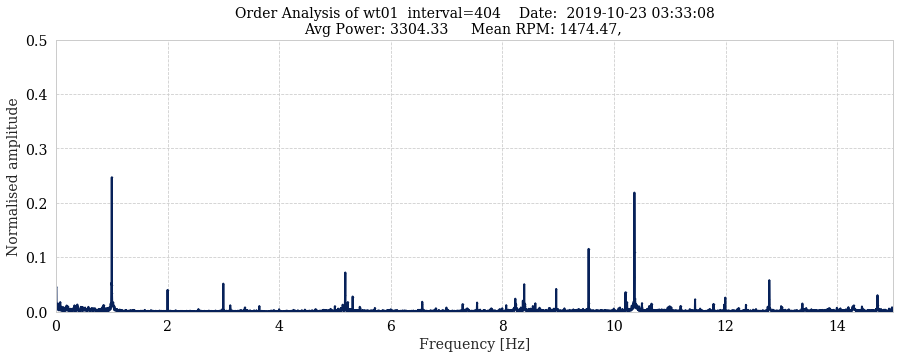

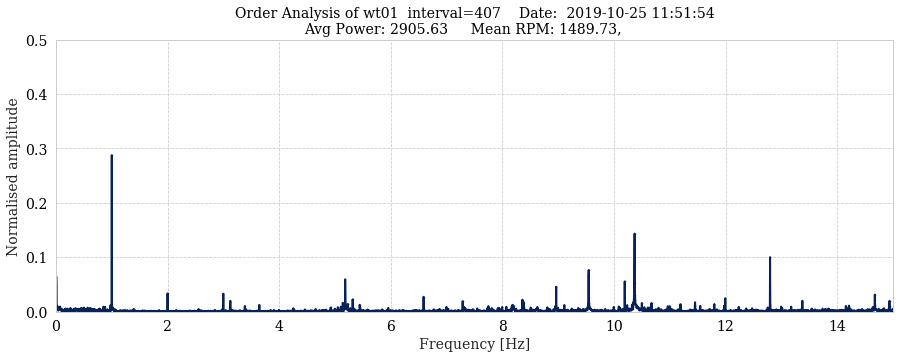

In [10]:
for i, order in enumerate(resampled_xs):
    if ((i < 30) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}  interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=15, y_max=0.5, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)



## 4. Development of the First 200 Orders

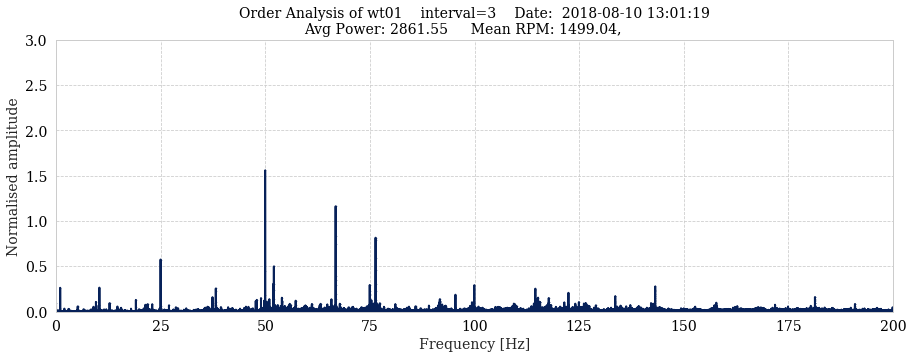

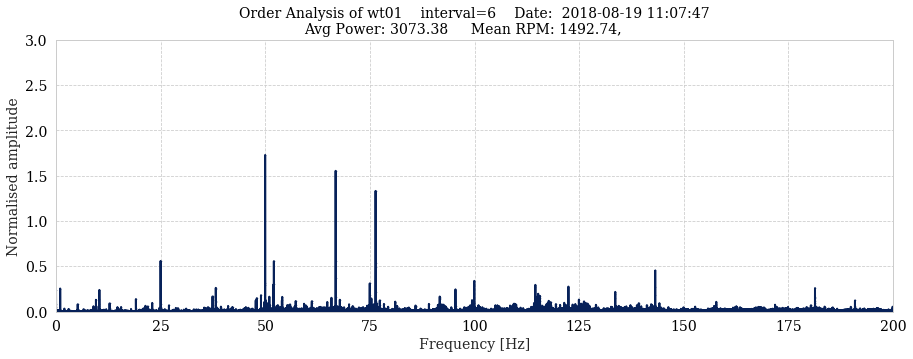

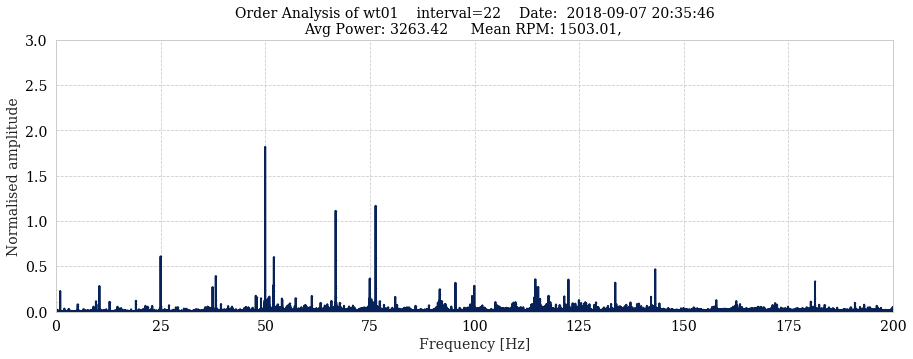

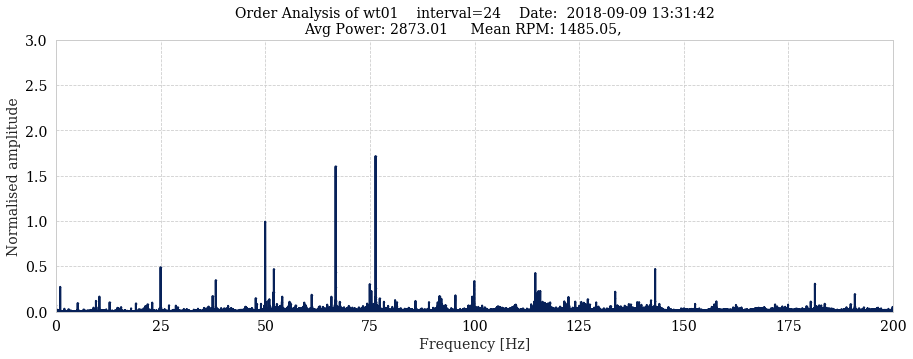

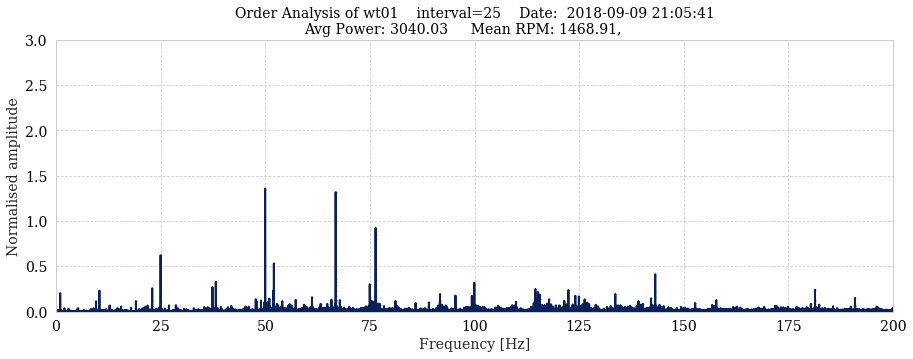

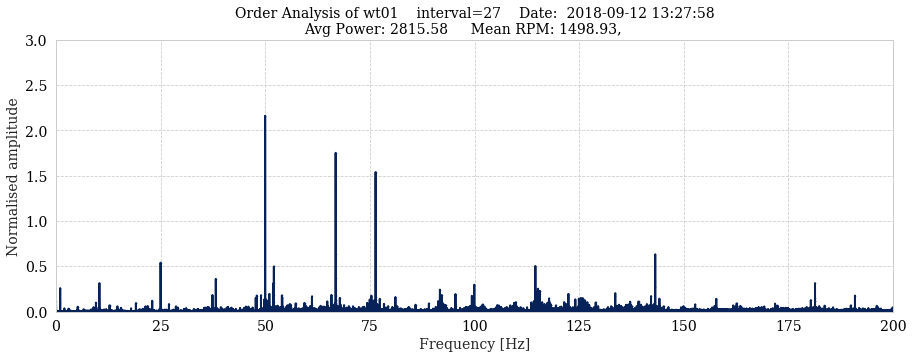

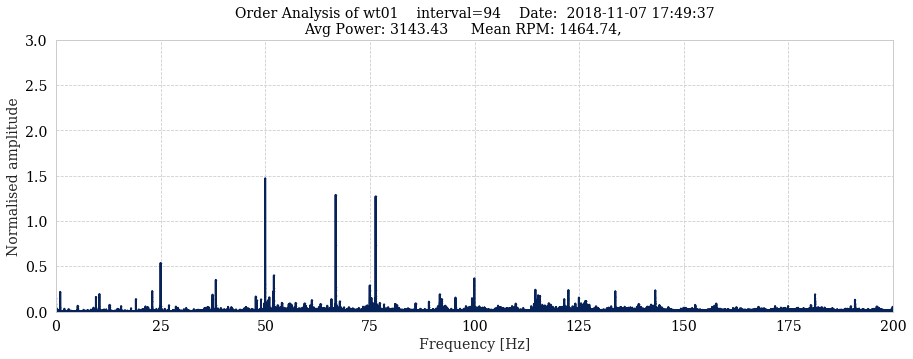

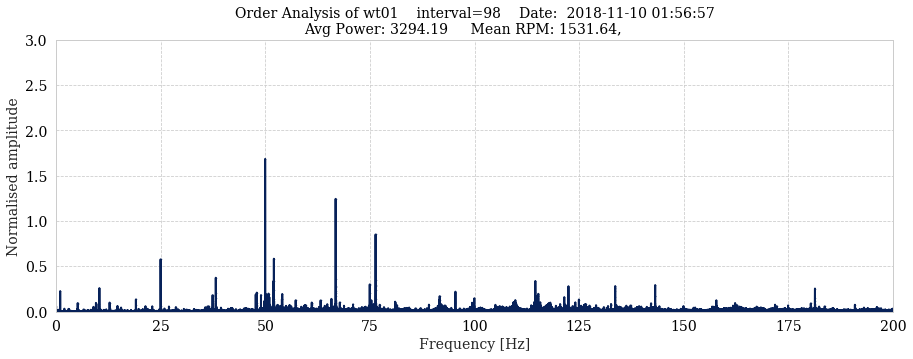

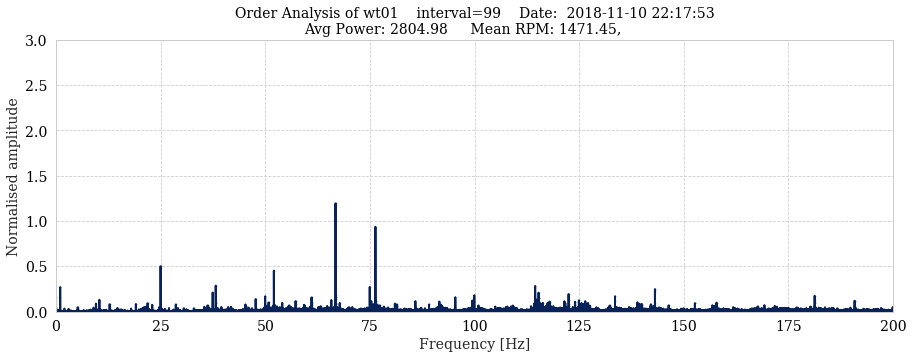

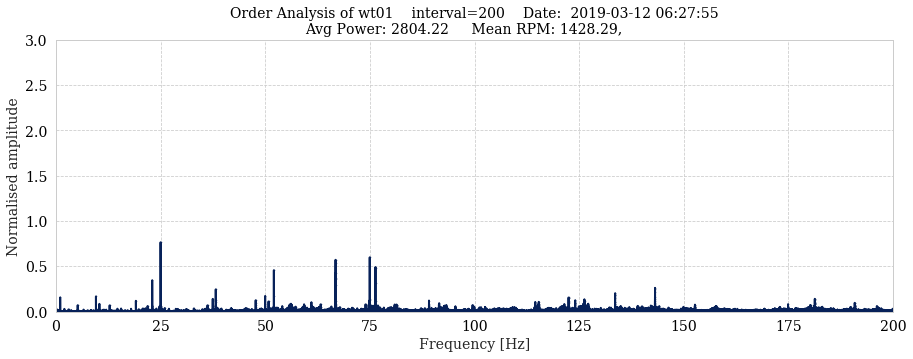

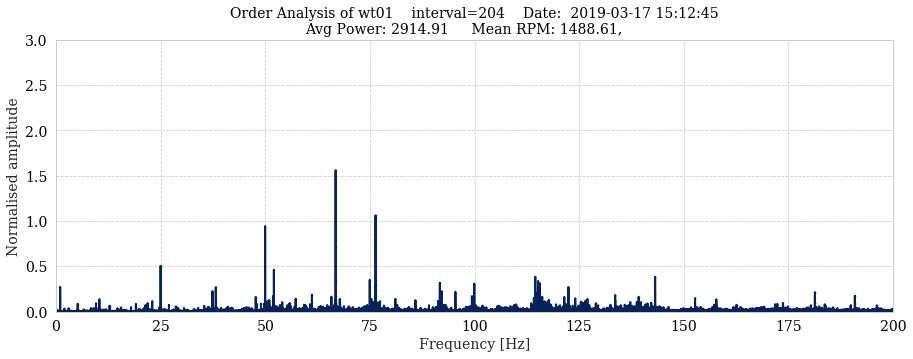

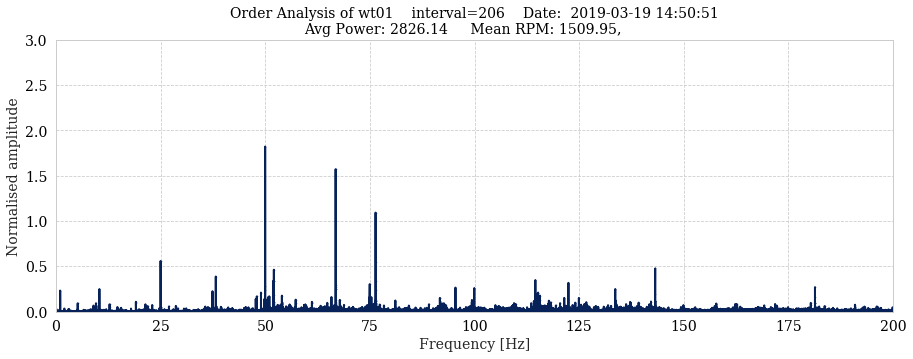

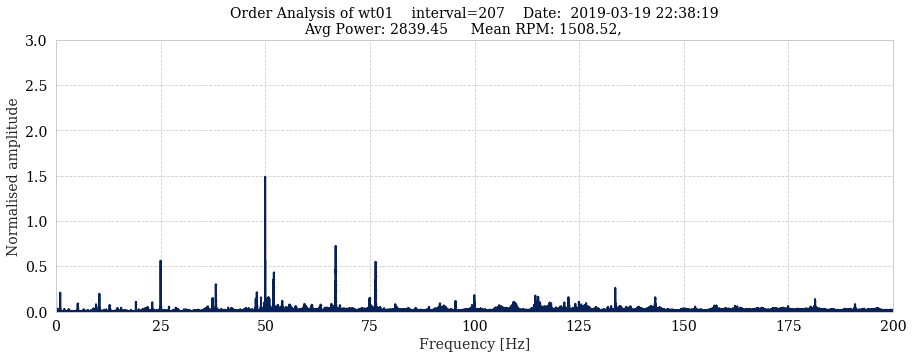

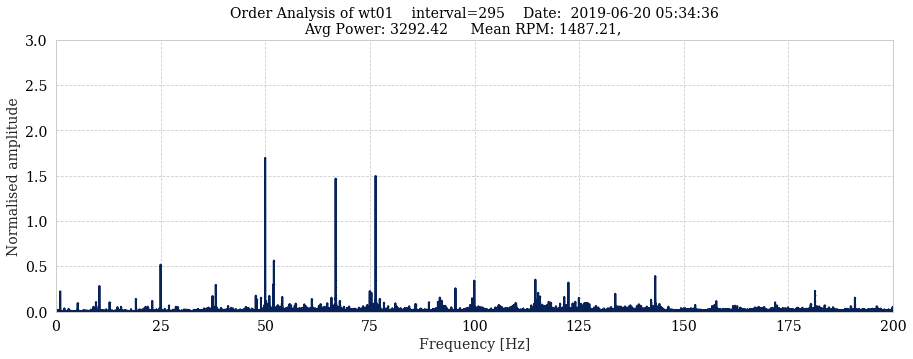

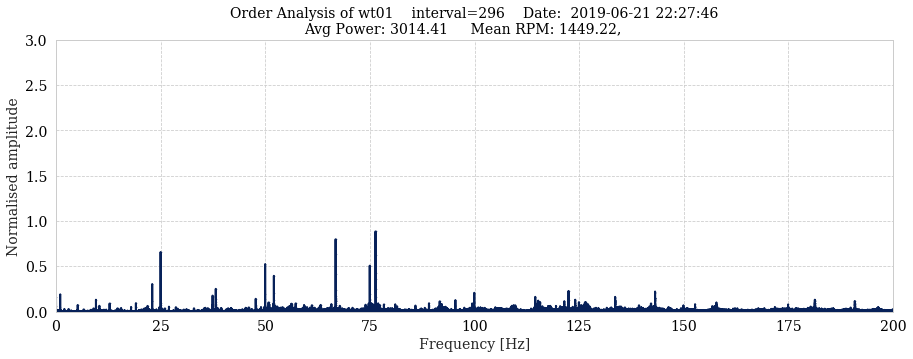

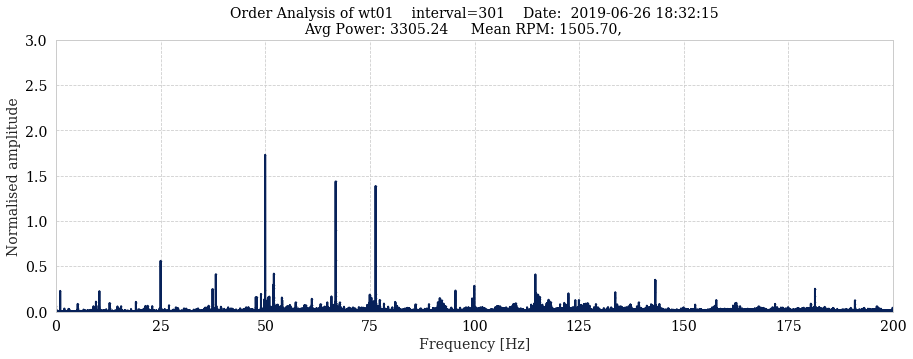

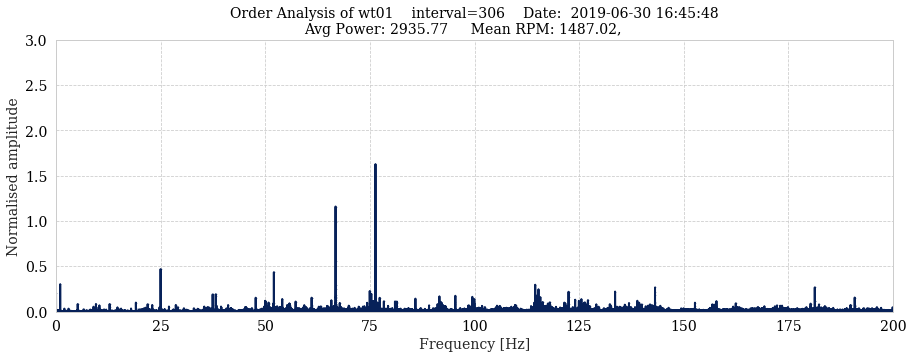

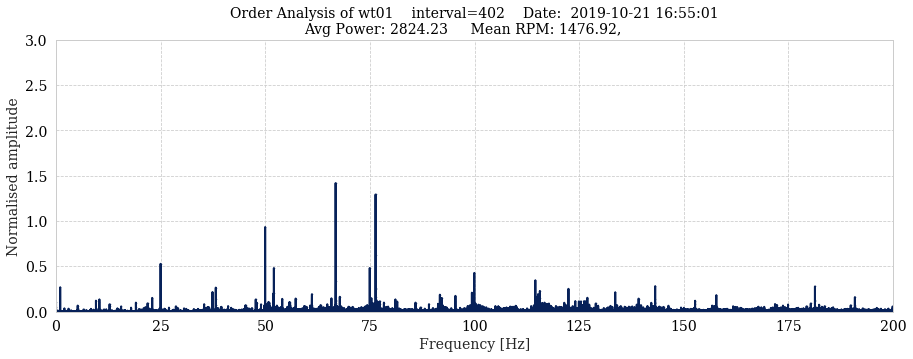

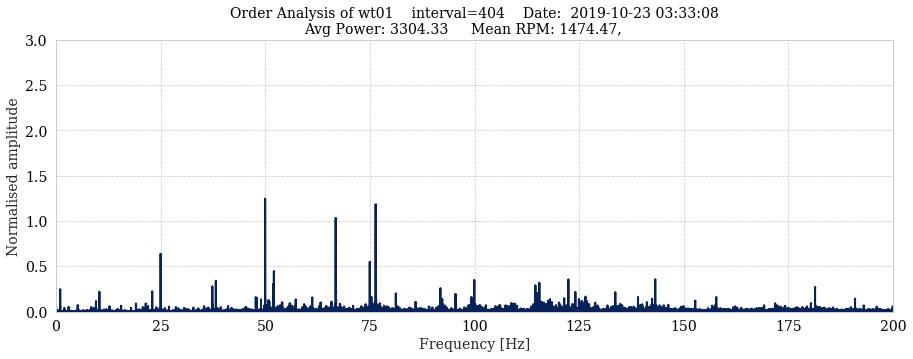

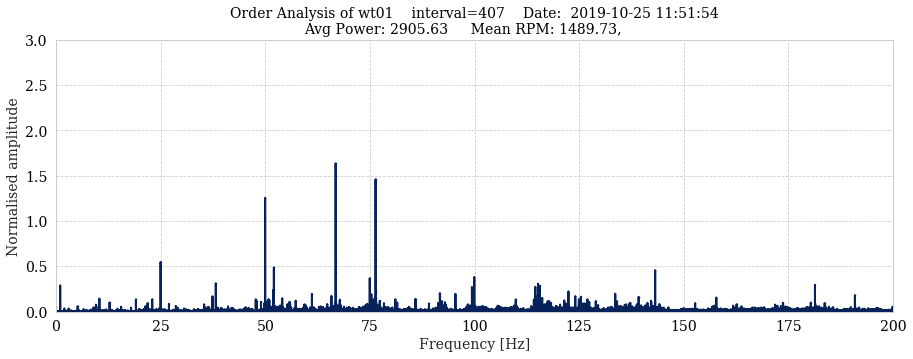

In [9]:
for i, order in enumerate(resampled_xs):
    if ((i < 30) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}    interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=200, y_max=3, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)


## 5. All Orders

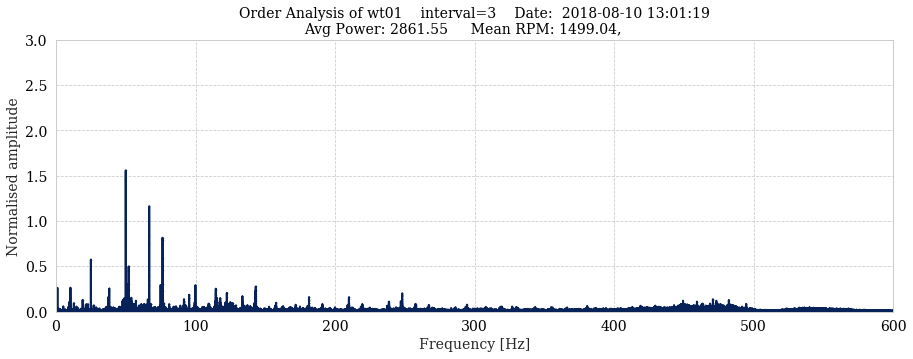

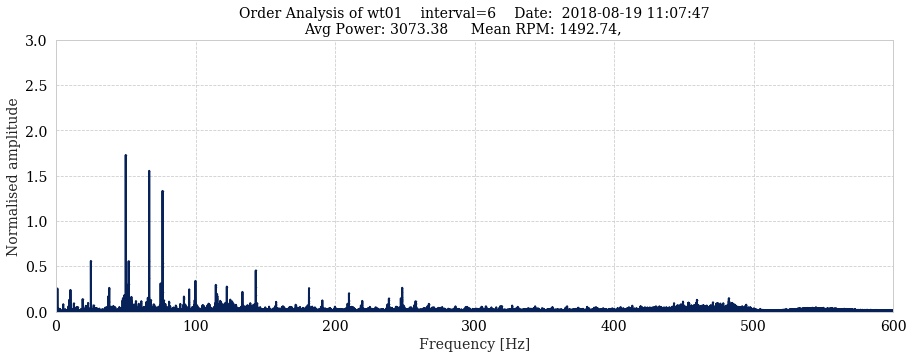

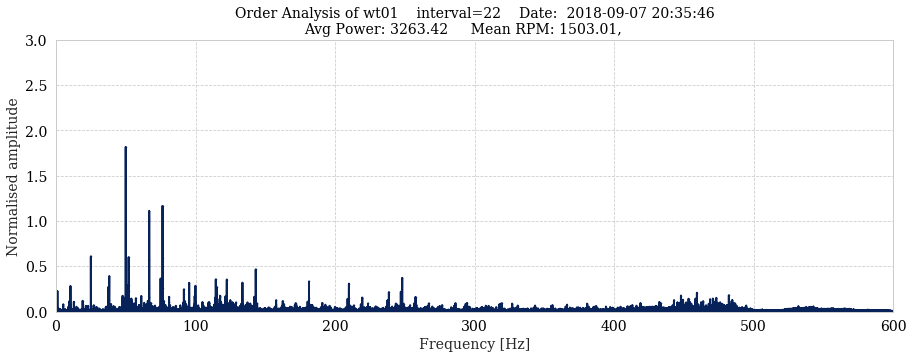

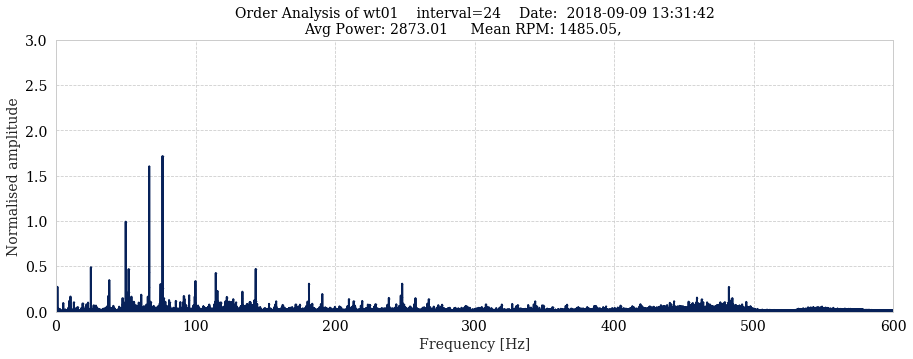

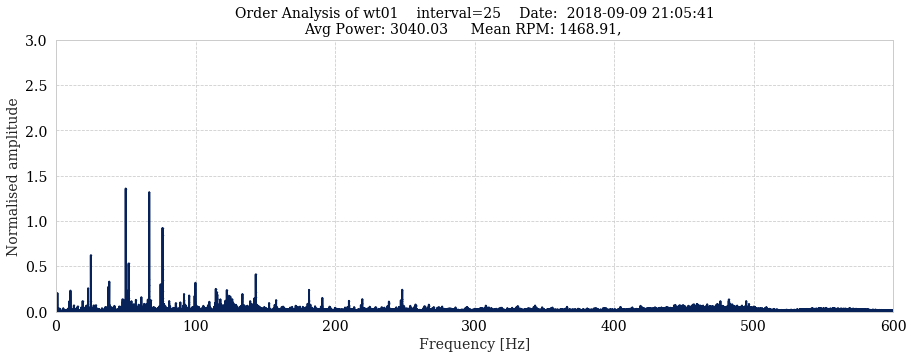

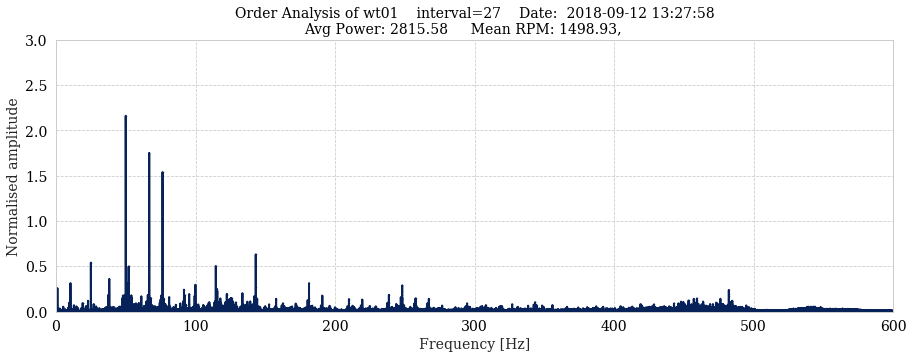

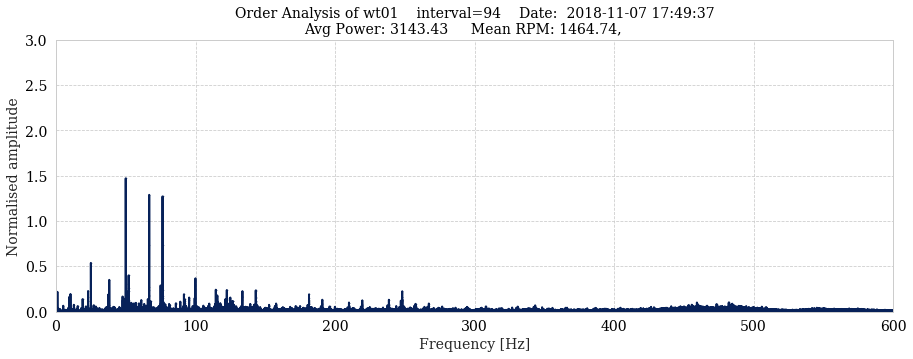

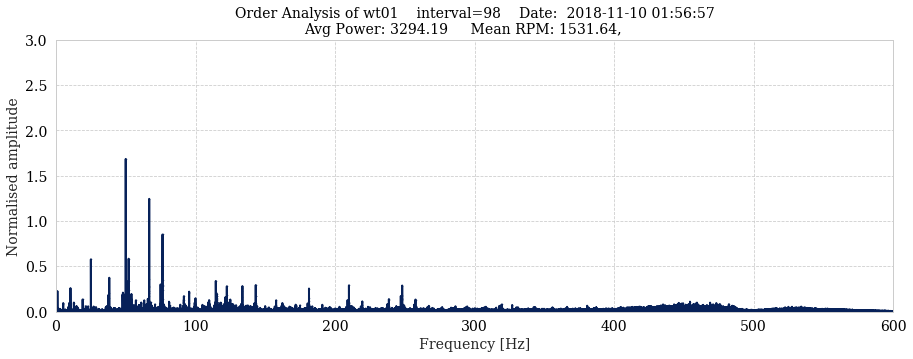

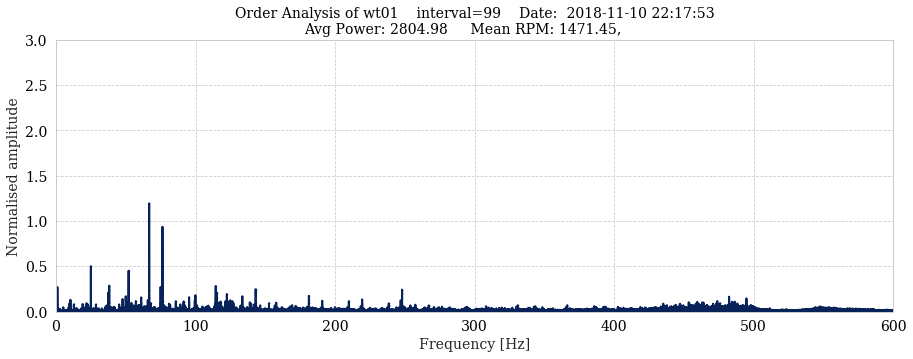

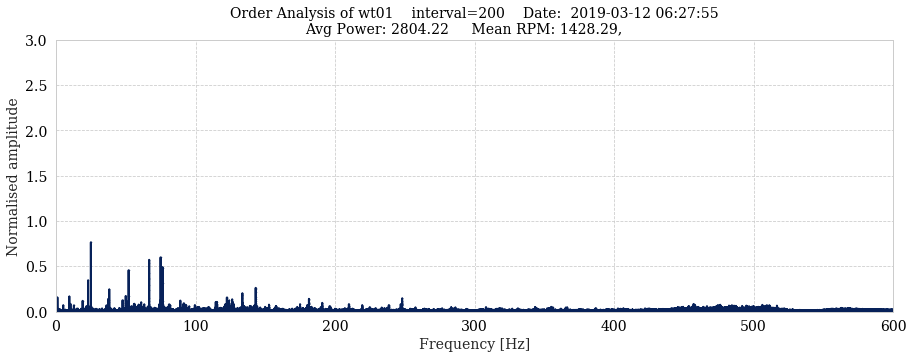

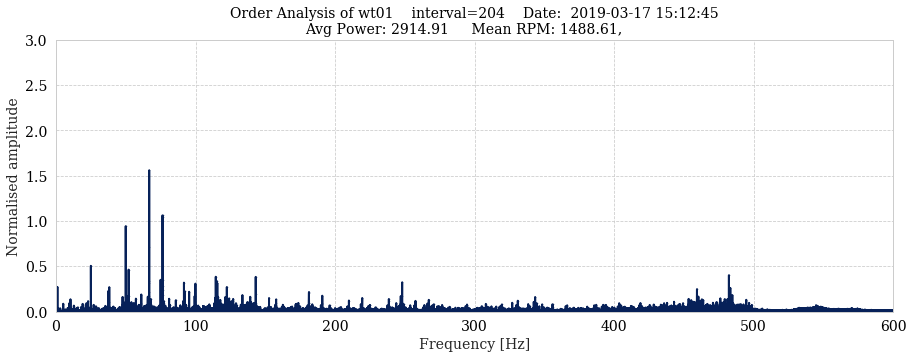

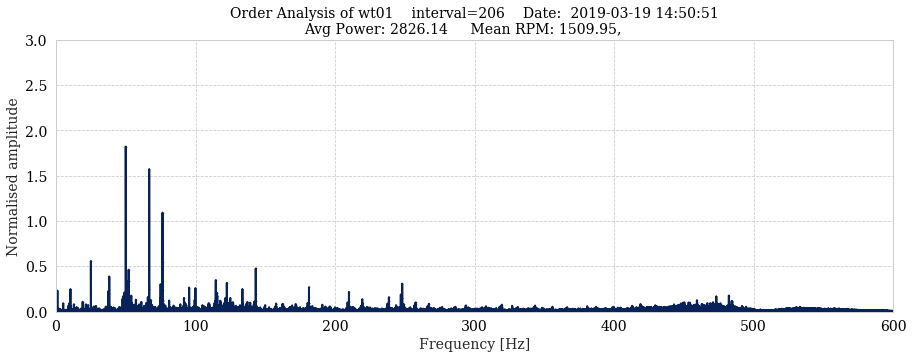

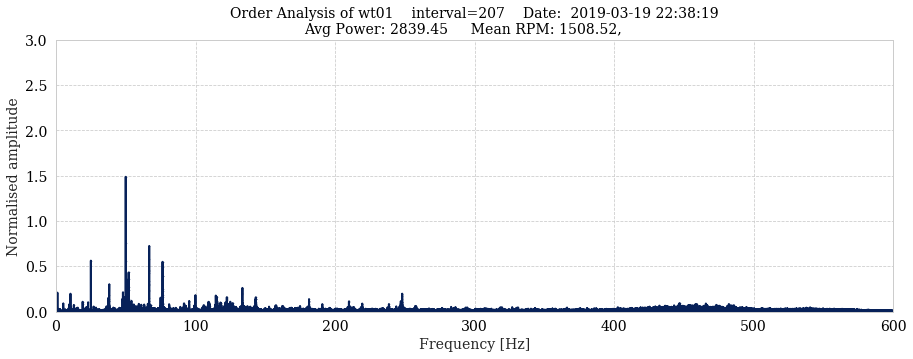

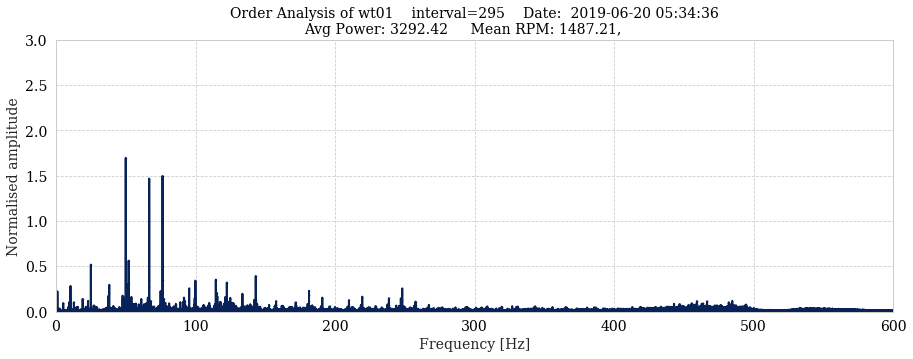

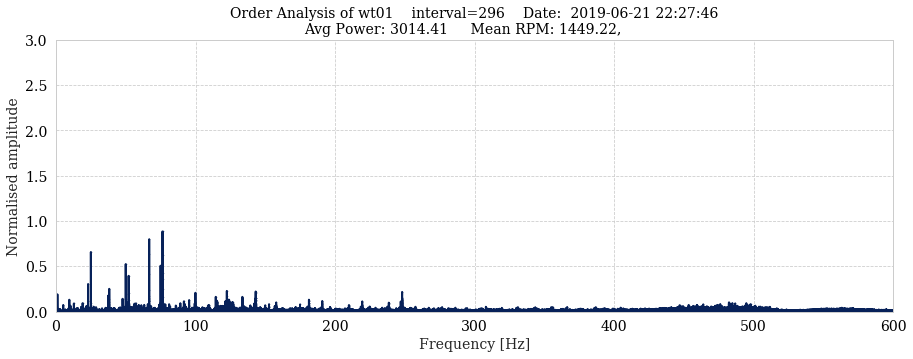

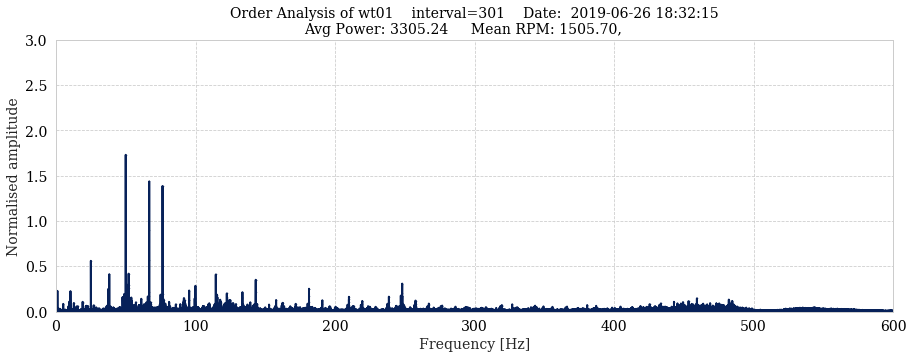

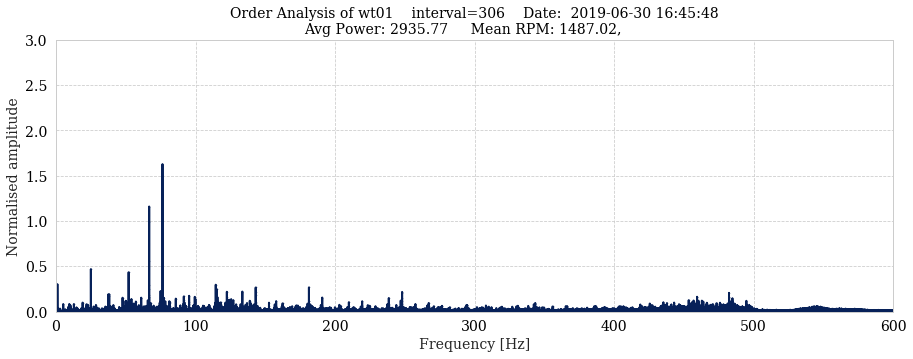

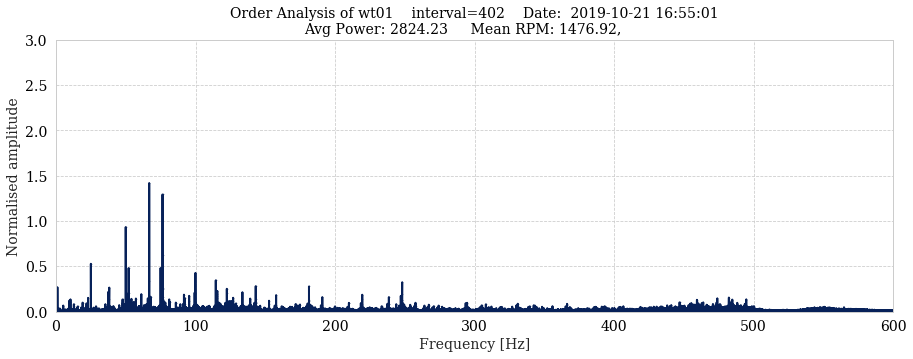

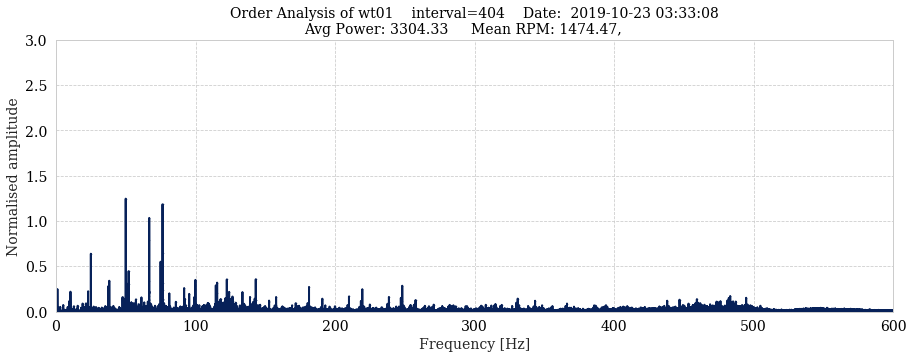

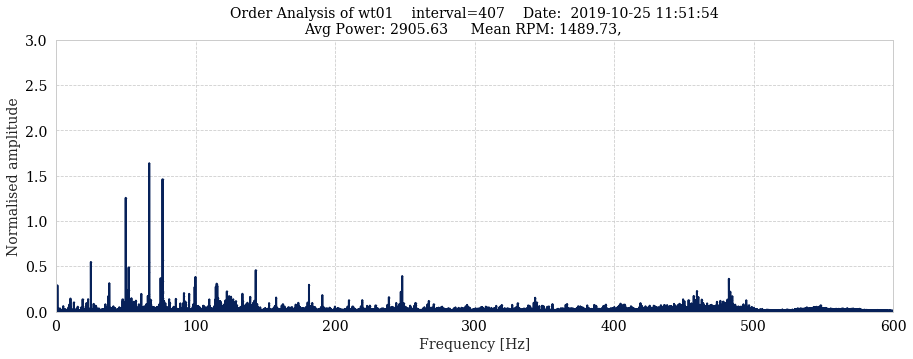

In [11]:
for i, order in enumerate(resampled_xs):
    if ((i < 30) or (i > 90 and i < 110) or (i > 190 and i < 210) or (i > 290 and i < 310) or (i > 400)) and (avg_power[i]>2800):
        title = f'Order Analysis of {turbine}    interval={i}    Date:  {dates.values[i][0]}\n'
        _,_ = plotting_methods.plot_fft(order, resampled_ys[i], x_max=600, y_max=3, avg_rpm=avg_rpm[i], avg_power=avg_power[i], name=title, default_title=False)


## 6. RMS all Signals wtih Avg Power > 2700

In [6]:
def normalise_fft(fft):
    N = fft.shape[0]
    y = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    return y

all_fft_x = []
all_fft_y = []

for i, order in enumerate(resampled_xs):
    if (avg_power[i]>2700):
        fft_res, freq_res = plotting_methods.plot_fft(resampled_xs[i], resampled_ys[i], x_max=500, y_max=None, avg_rpm=avg_rpm[i], avg_power=avg_power[i])
        all_fft_x.append(freq_res)
        all_fft_y.append(normalise_fft(fft_res))
    print(i, end='\r')

In [7]:
def rms_bin(amp):
        sum = 0
        for a in amp:
            sum += a ** 2
        rms = np.sqrt(2 * sum)
        return rms

In [8]:

bins = 50000

all_rms = []
all_x   = []
    
for j in range(len(all_fft_x)):
    f = all_fft_x[j]
    y_norm = all_fft_y[j]
    rms_bins = []
    frequency_bins = np.linspace(0, max(f), bins + 1)
    frequency_bins = np.linspace(0, 500, bins + 1)
    if True:
        delta_f = f[1] - f[0]

        # Finding the correct indices to separate frequency and amplitude correctly.
        bin_indexes = [0]
        # Since the first index is already added to bin_indexes we start frequency_bins_index at 1
        frequency_bins_index = 1
        for i in range(len(f)):
            if frequency_bins_index > bins:
                break
            if f[i] >= frequency_bins[frequency_bins_index]:
                frequency_bins_index += 1
                bin_indexes.append(i)
        for i in range(len(bin_indexes) - 1):
            amp = y_norm[bin_indexes[i]:bin_indexes[i + 1]]  # Calculating the rms between two indexes
            rms_bins.append(rms_bin(amp))
            #rms_bins.append(np.mean(amp))
    x = [(frequency_bins[a] + frequency_bins[a + 1]) / 2 for a in
         range(len(frequency_bins) - 1)]  # The frequency index for the bins!
    
    all_rms.append(rms_bins)
    all_x.append(x)
    print(j, end='\r')


Real: 49.97609605912031
Simulated: 66.815


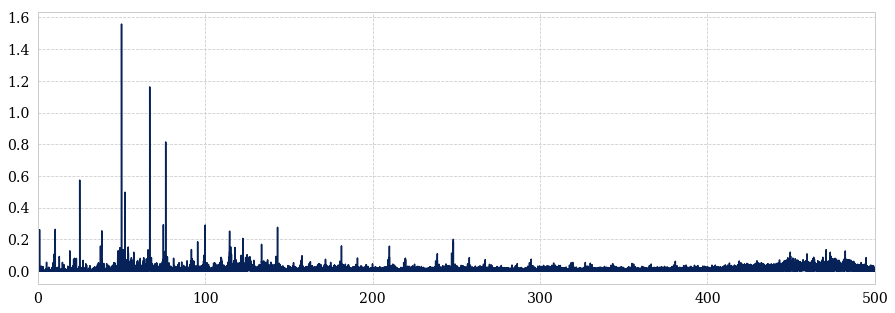

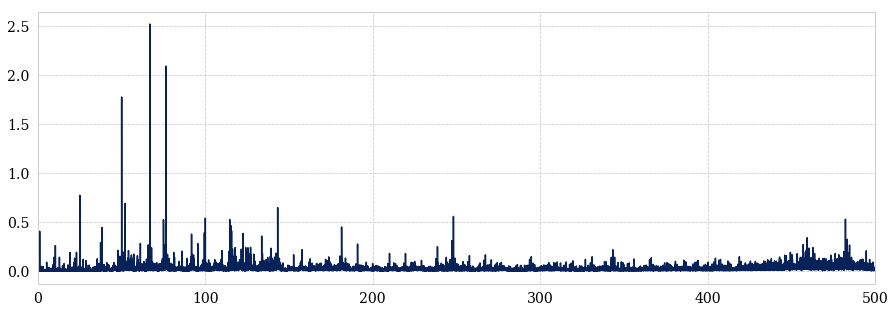

Real: 49.97609390398659
Simulated: 49.975


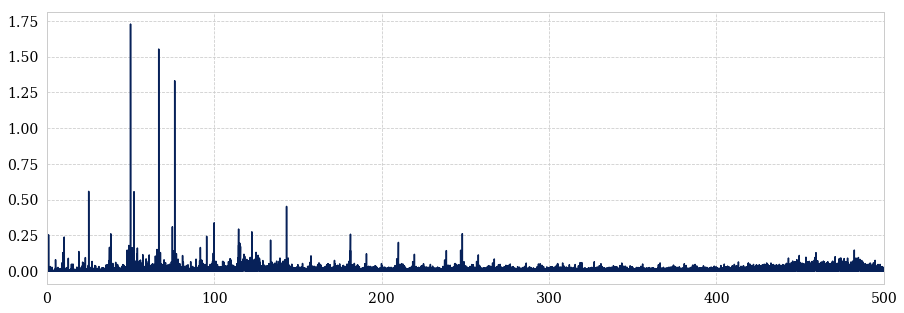

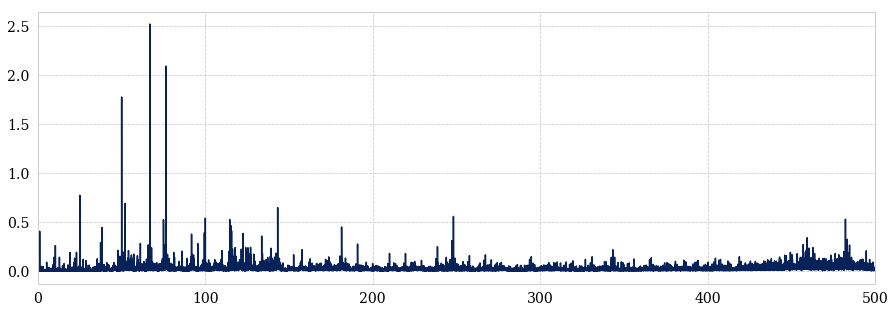

Real: 76.32126580201857
Simulated: 76.325


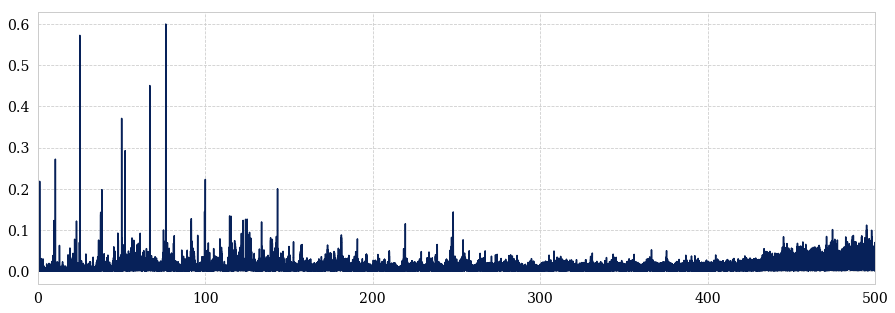

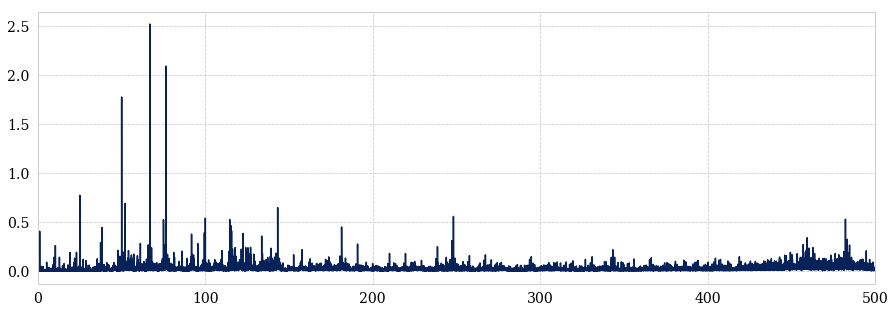

Real: 66.80807785884416
Simulated: 66.805


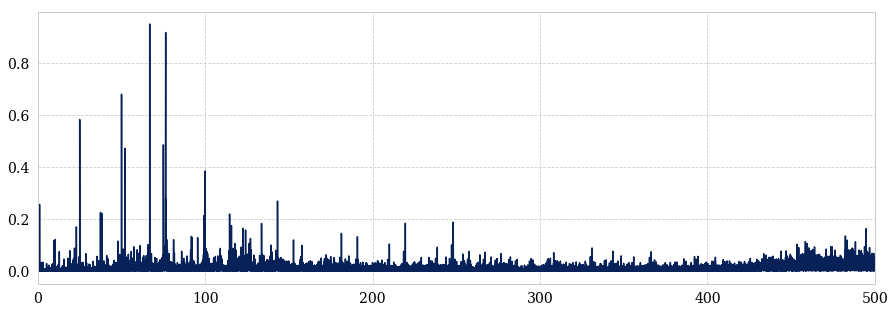

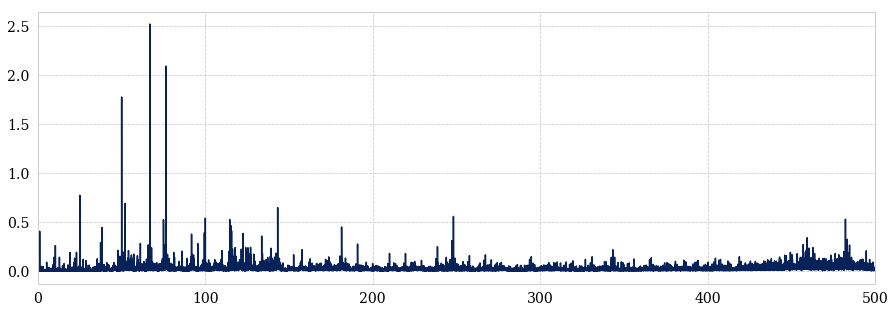

Real: 49.97609019956417
Simulated: 49.975


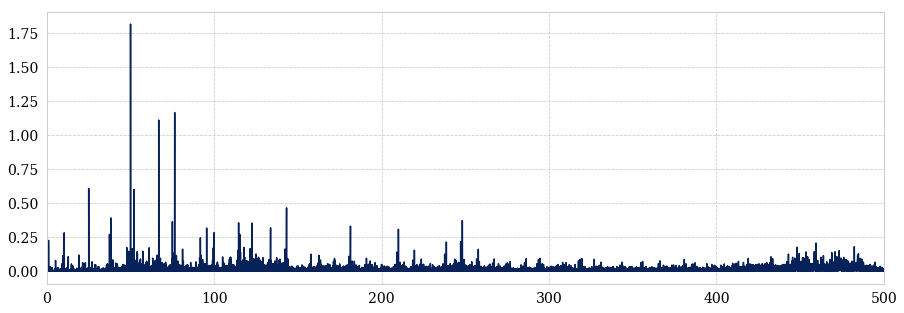

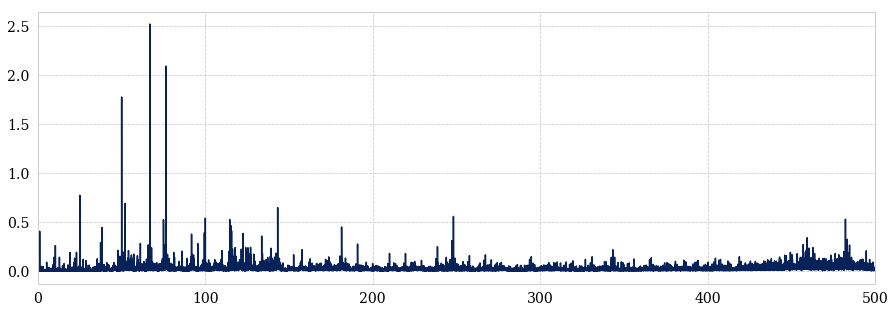

Real: 76.35238120573804
Simulated: 76.355


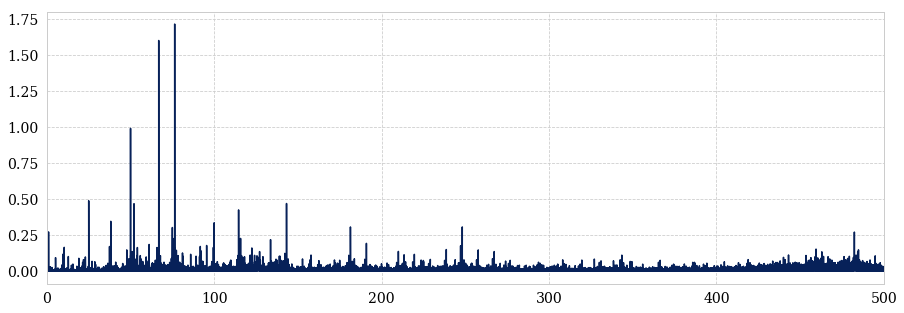

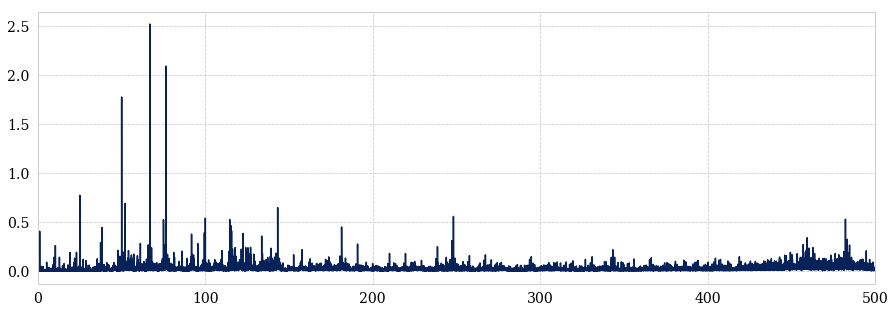

Real: 49.97609411260006
Simulated: 49.975


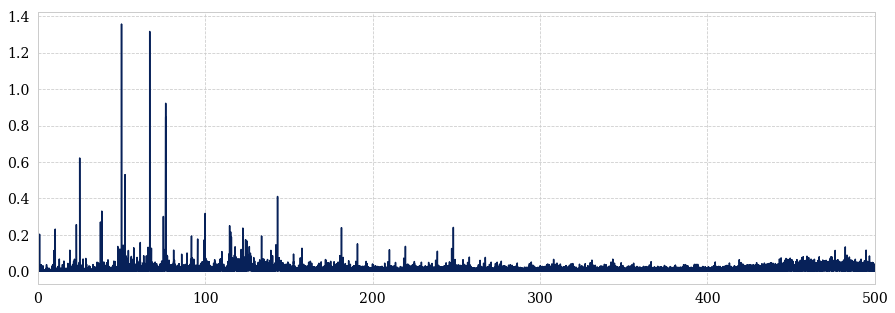

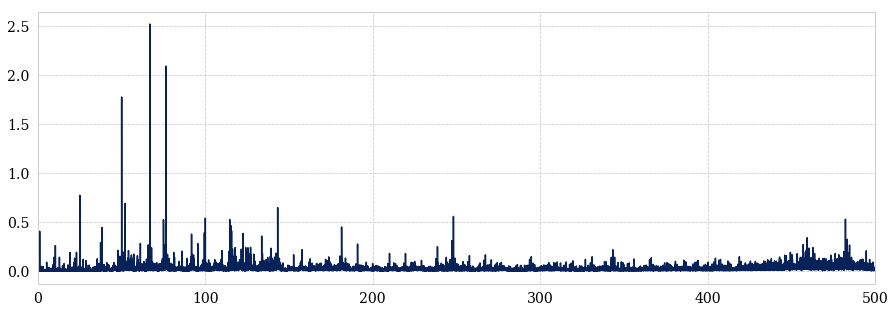

Real: 49.976099965580566
Simulated: 49.975


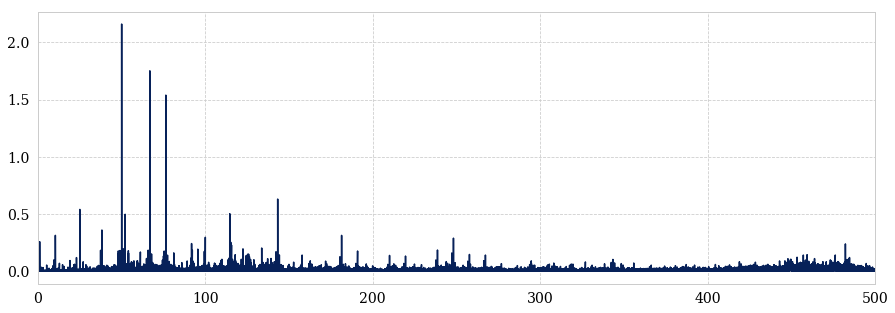

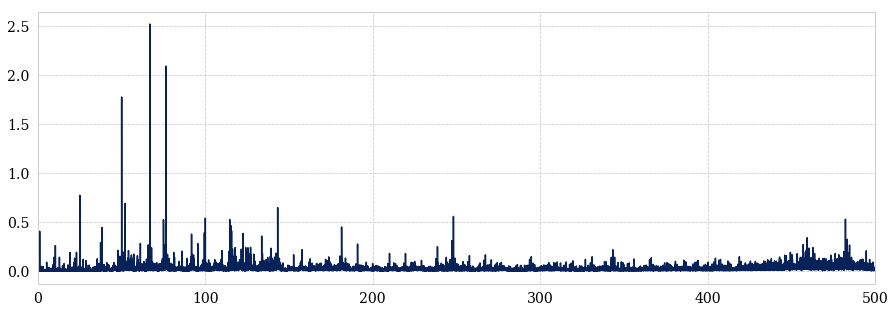

Real: 76.33300967152658
Simulated: 76.33500000000001


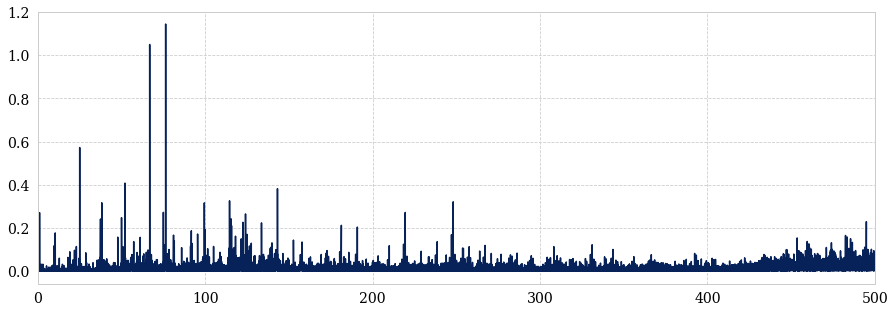

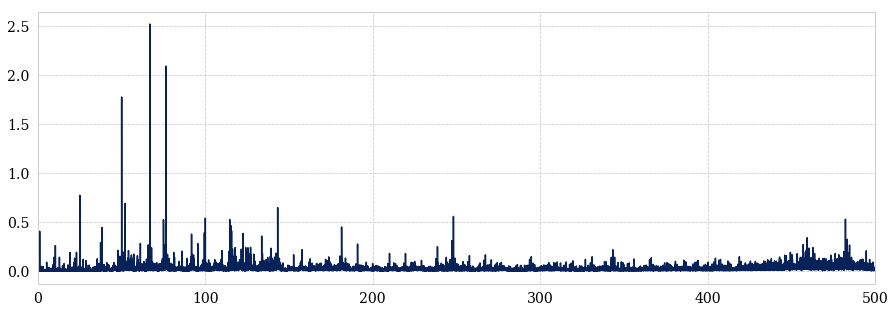

Real: 66.82170070631605
Simulated: 66.825


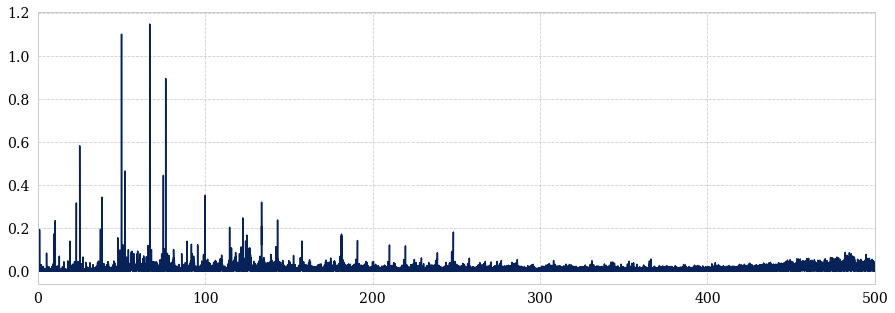

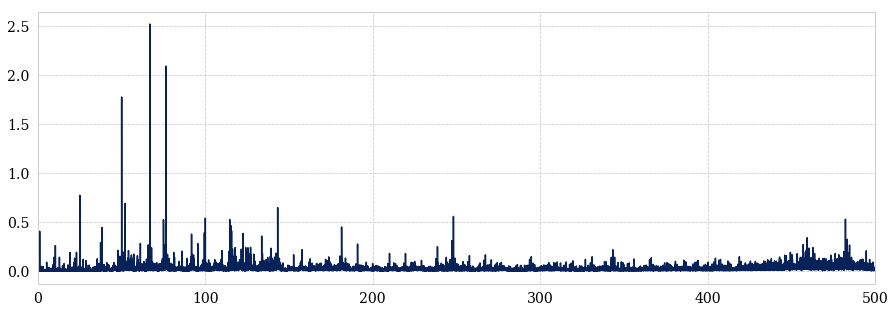

In [10]:
for i in range(10):
    print(f'Real: {all_fft_x[i][np.argmax(all_fft_y[i])]}')
    print(f'Simulated: {all_x[i][np.argmax(all_rms[i])]}')
    
    plt.figure(figsize=(15,5))
    plt.plot(all_fft_x[i], all_fft_y[i])
    plt.xlim(0,500)
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(x,rms_bins)
    plt.xlim(0,500)
    plt.show()

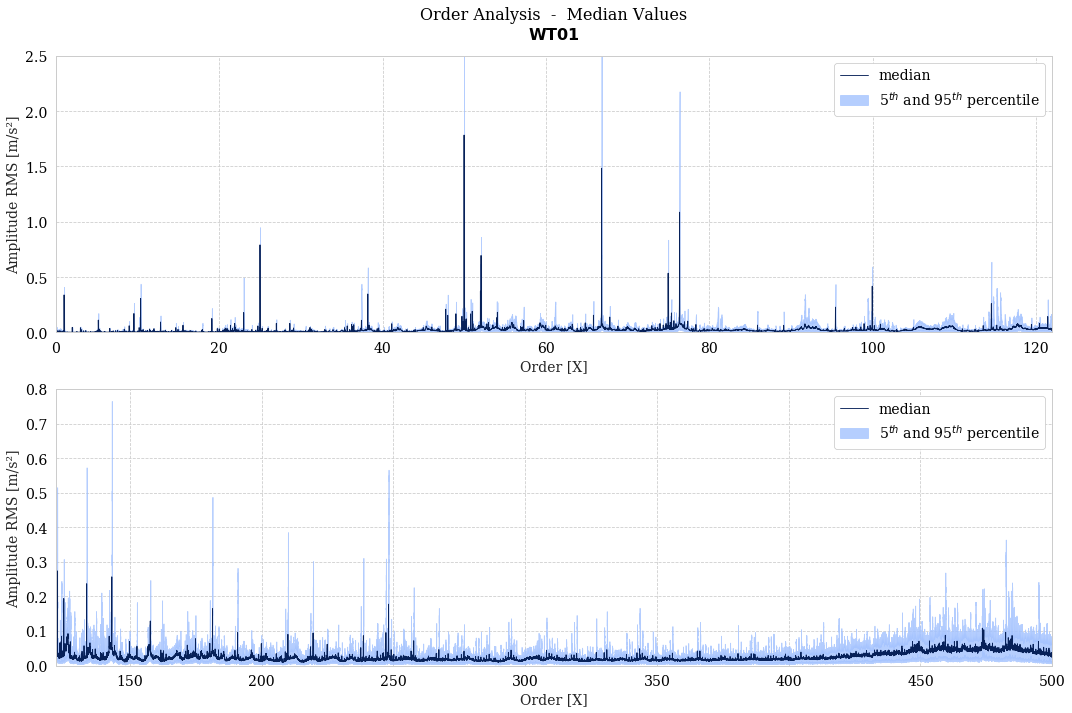

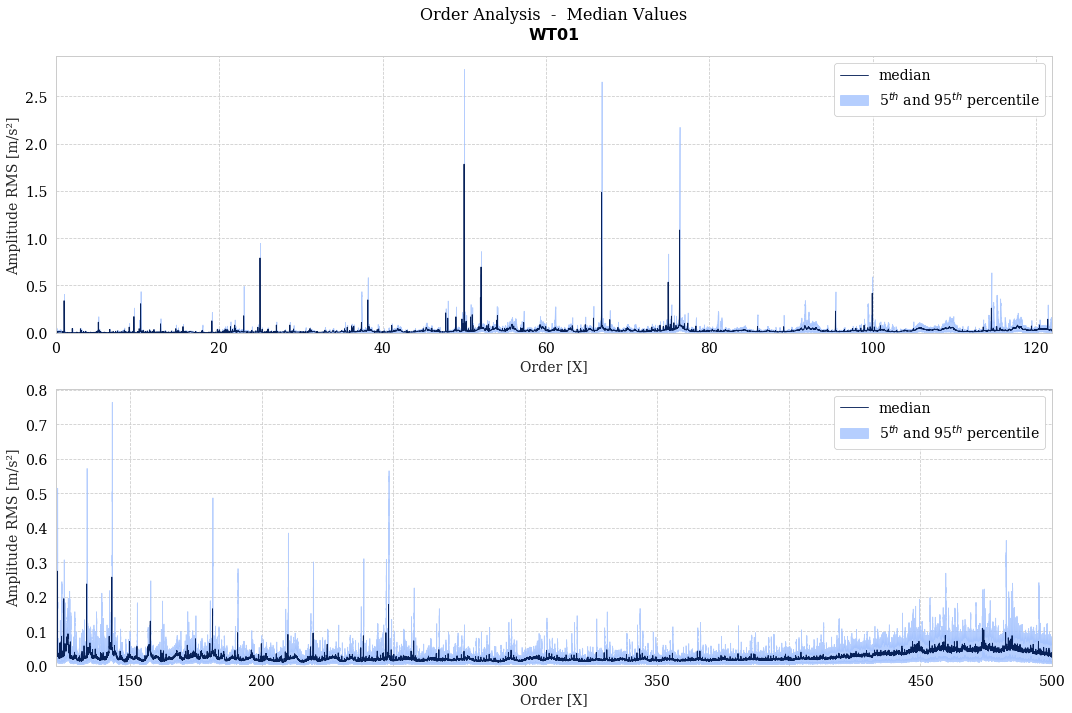

In [17]:
rms_df = pd.DataFrame(all_rms)
plot_path = f'../../plots/results/rms_orders_{turbine}_equal_scale'
heading = 'Order Analysis  -  Median Values\n' + r"$\bf{WT01}$"
data_statistics.plot_median_rms(rms_df, x=np.asarray(all_x[0]), split=True, save_path=plot_path, y_max=2.5, y_max2=0.8, title=heading)
data_statistics.plot_median_rms(rms_df, x=np.asarray(all_x[0]), split=True, save_path=None, title=heading)